# Problem 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lib_hcy_week5 import myfunctions as mf
from scipy.stats import t, norm

In [2]:
p1_data = pd.read_csv("problem1.csv")
p1_data.head()

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284


In [3]:
def cal_ES(var, sim_data):
  return -np.mean(sim_data[sim_data <= -var])

In [4]:
var_norm, dist_norm = mf.norm_VaR(p1_data)
es_norm = cal_ES(var_norm, dist_norm)
print("Under Normal Distribution, VaR is {:.4f}, ES is {:.4f}".format(round(var_norm, 4), round(es_norm, 4)))

Under Normal Distribution, VaR is 0.0831, ES is 0.1033


In [5]:
var_t, dist_t = mf.MLE_T_VaR(p1_data)
es_t = mf.cal_ES(var_t, dist_t)
print("Under Generalized T Distribution, VaR is {:.4f}, ES is {:.4f}".format(round(var_t, 4), round(es_t, 4)))

Under Generalized T Distribution, VaR is 0.0735, ES is 0.1076


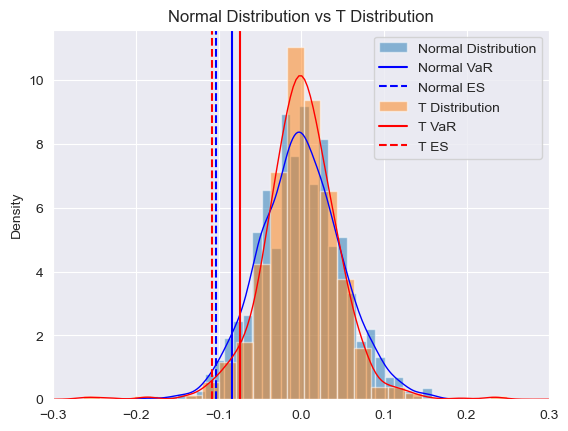

In [6]:
plt.hist(dist_norm, bins=30, density=True, alpha=0.5, label='Normal Distribution') # draw histogram, bins interval is 30, density is True for "the weights are normalized, so that the integral of the density over the range remains 1", alpha 0.5 is half transparent (1 is not transparent), label for legend
sns.kdeplot(dist_norm, color='blue', linewidth=1) # KDE smooth line graph shape
plt.axvline(-var_norm, label='Normal VaR', color='blue', linestyle='-') # draw vertical line at -var_norm
plt.axvline(-es_norm, label='Normal ES', color='blue', linestyle='--')
plt.hist(dist_t, bins=30, density=True, alpha=0.5, label='T Distribution')
sns.kdeplot(dist_t, color='red', linewidth=1)
plt.axvline(-var_t, label='T VaR', color='red', linestyle='-')
plt.axvline(-es_t, label='T ES', color='red', linestyle='--')
plt.xlim(-0.3, 0.3) # limit x to be -0.3 to 0.3, center the graph
plt.legend(loc='upper right') # keep the legend on upper right corner
plt.ylabel('Density') # y-axis label
plt.title('Normal Distribution vs T Distribution') # graph name
plt.show()

# Problem 2

In [7]:
# test covariance estimation
df = pd.read_csv("DailyPrices.csv")
all_ret = mf.return_calculate(df)
all_ret.drop('Date', axis=1, inplace=True)

expo_w_cov = mf.expo_weighted_cov(all_ret)

ps_var_ps_cor = mf.cal_ps_var_ps_cor(all_ret)
ew_var_ew_cor = mf.cal_ew_var_ew_cor(all_ret)
ew_var_ps_cor = mf.cal_ew_var_ps_cor(all_ret)
ps_var_ew_cor = mf.cal_ps_var_ew_cor(all_ret)

print(ps_var_ps_cor.shape)
print(ew_var_ew_cor.shape)
print(ew_var_ps_cor.shape)
print(ps_var_ew_cor.shape)

(101, 101)
(101, 101)
(101, 101)
(101, 101)


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/lib_hcy_week5/myfunctions.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]
/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/lib_hcy_week5/myfunctions.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]
/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/lib_hcy_week5/myfunctions.py:45: RuntimeWarning: invalid value encountered in reciprocal
  invSD = np.diag(np.reciprocal(np.sqrt(np.diag(ew_cov))

In [8]:
# test non PSD fixes
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

is_psd1 = mf.is_psd(sigma)
print(is_psd1)

near_sigma = mf.near_psd(sigma)
is_psd2 = mf.is_psd(near_sigma)
print(is_psd2)

weight = np.identity(sigma.shape[0])
higham_sigma = mf.higham_psd(sigma, weight)
is_psd3 = mf.is_psd(higham_sigma)
print(is_psd3)

False
True
True


In [9]:
# test simulation methods
simu_from_cov = mf.simu_from_cov(ew_var_ew_cor, 1000)
simu_from_pca = mf.simu_from_pca(ew_var_ew_cor, 1000, 0.97)

print(simu_from_cov.shape)
print(simu_from_pca.shape)

(1000, 101)
(1000, 101)


In [10]:
# test VaR calculation methods
META = all_ret['META']
META_centered = META - META.mean()

norm_VaR, _ = mf.norm_VaR(META_centered)
norm_ew_VaR, _ = mf.norm_VaR(META_centered)
MLE_T_VaR, _ = mf.MLE_T_VaR(META_centered)
ar1_VaR, _ = mf.ar1_VaR(META_centered)
his_VaR, _ = mf.his_VaR(META_centered)
print(norm_VaR)
print(norm_ew_VaR)
print(MLE_T_VaR)
print(ar1_VaR)
print(his_VaR)

0.053132089652322634
0.051077647240355344
0.042160603381578836
0.05244220187163839
0.03948424995533789


In [11]:
# test ES calculation
# already tested in Problem 1 code, var_t, dist_t = mf.MLE_T_VaR(p1_data), es_t = mf.cal_ES(var_t, dist_t)

# Problem 3

In [12]:
portfolio = pd.read_csv('portfolio.csv')
prices = pd.read_csv('DailyPrices.csv')

portfolioA = portfolio[portfolio['Portfolio'] == 'A'].drop('Portfolio', axis = 1)
portfolioB = portfolio[portfolio['Portfolio'] == 'B'].drop('Portfolio', axis = 1)
portfolioC = portfolio[portfolio['Portfolio'] == 'C'].drop('Portfolio', axis = 1)

all_assets = portfolio.drop('Portfolio', axis = 1) # the default drop drops rows, use axis = 1 to indicate drop a column
portfolioT = all_assets.groupby(["Stock"], as_index=False)["Holding"].sum() # as_index makes Stock column a real column, not index column

In [13]:
def cal_port_tDist(aPortfolio, prices):
  # step 1, collect historical data
  daily_price, holdings, port_value = mf.parsing_port(aPortfolio, prices)

  # step 2, calculate returns, default to be arithmatic
  asset_returns = mf.return_calculate(daily_price)
  asset_returns.drop("Date", axis=1, inplace=True) # 1 means modify on original df
  asset_returns_mean = asset_returns.mean()
  asset_returns = asset_returns - asset_returns_mean

  returns_R_U = asset_returns.copy()

  # step 3, transform rit to uit, using T distribution
  for asset in returns_R_U.columns.tolist(): # an array of stock names
    result = t.fit(asset_returns[asset], method="MLE")
    df = result[0]
    loc = result[1]
    scale = result[2]
    returns_R_U[asset] = t.cdf(asset_returns[asset], df=df, loc=loc, scale=scale)

  # step 4, transform uit to zit, not necessary if we use Spearman correlation
  returns_U_Z = pd.DataFrame(norm.ppf(returns_R_U), index=returns_R_U.index, columns=returns_R_U.columns) # keep the identifier for rows and columns the same

  # step 5, estimate correlation matrix, we use Spearman here
  spearman_corr_mtx = returns_U_Z.corr(method='spearman')
  std_vector = returns_U_Z.std() # simu_from_pca() only accept covariance matrix, we have to convert
  spearman_cov_mtx = spearman_corr_mtx * np.outer(std_vector, std_vector)

  # step 6, Monte Carlo random simulation, cholesky or PCA, we use PCA here
  simulations = mf.simu_from_pca(spearman_cov_mtx, 1000, 1)
  df_simu = pd.DataFrame(simulations, columns=returns_U_Z.columns)

  # step 7, convert back yit (simulated zit) to uit
  returns_Z_U = pd.DataFrame(norm.cdf(df_simu), index=df_simu.index, columns=df_simu.columns)

  returns_U_R = returns_Z_U.copy()

  # step 8, convert uit to rit, using the same parameters from step 3
  for asset in returns_U_R.columns.tolist():
      result = t.fit(asset_returns[asset], method="MLE")
      df = result[0]
      loc = result[1]
      scale = result[2]
      returns_U_R[asset] = t.ppf(returns_Z_U[asset], df=df, loc=loc, scale=scale)

  # step 9, calculate simulated portfolio returns
  actual_returns = np.add(returns_U_R, asset_returns_mean)
  latest_prices = daily_price.drop("Date", axis=1).tail(1).values.reshape(-1, 1)
  pchange = actual_returns * latest_prices.T
  holdings = holdings.values.reshape(-1, 1)
  simulated_returns = pchange @ holdings

  # step 10, calculate VaR
  var = mf.calculate_VaR(simulated_returns, alpha=0.05)

  # step 11, calculate ES
  es = mf.cal_ES(var, simulated_returns)[0]
  return var, es

In [14]:
var_A, es_A = cal_port_tDist(portfolioA, prices)
print(var_A, es_A)
var_B, es_B = cal_port_tDist(portfolioB, prices)
print(var_B, es_B)
var_C, es_C = cal_port_tDist(portfolioC, prices)
print(var_C, es_C)
var_T, es_T = cal_port_tDist(portfolioT, prices)
print(var_T, es_T)

/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


20670.44932424852 26400.667490566833


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


12084.303056014376 15977.953681423514


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/lib_hcy_week5/myfunctions.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


26035.675842245248 35715.85417669866
61368.60293912821 78891.85385549559


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
